<h1 style="color:blue; text-align:center"><span style="color:red">|</span> DESCRIPTION OF DATA <span style="color:red">|</span></h1>

**Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.**

The data we are going to use have the following features.

|**Variable Name** | **Role** | **Type** | **Description** | **Units** | **Missing Values** |
| :---- | :-----: | :----: | :---- | :----: | :----: |
|Sex | Feature | Categorical | M, F, and I (infant) | | no |
|Length | Feature | Continuous | Longest shell measurement | mm | no |
|Diameter | Feature | Continuous | perpendicular to length | mm | no |
|Height | Feature | Continuous |  with meat in shell | mm | no |
|Whole_weight | Feature | Continuous | whole abalone | grams | no
|Shucked_weight | Feature | Continuous | weight of meat | grams | no |
|Viscera_weight | Feature | Continuous | gut weight (after bleeding) | grams | no |
|Shell_weight | Feature | Continuous | after being dried | grams | no |
|Rings | Target | Integer | +1.5 gives the age in years | | no |

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> IMPORTING MODULES <span style="color:red">|</span></h1>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

from scipy.stats import boxcox, yeojohnson

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> IMPORTING DATA <span style="color:red">|</span></h1>

**I have included data from both playground-series as well as the original abalone data.**

In [13]:
file_path = "train.csv"
orig_path = "abalone.csv"

df = pd.read_csv(file_path,index_col='id')
orig_data = pd.read_csv(orig_path)

In [14]:
orig_data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

**Since the original dataset and the playground series dataset have different column names, we must rename then columns. Then we can concatenate them to form our complete dataset.**

In [15]:
df.columns = orig_data.columns

In [16]:
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [17]:
df = pd.concat([df,orig_data])
df = df.reset_index(drop=True)

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> EDA OF FEATURE VARIABLES <span style="color:red">|</span></h1>

In [18]:
df.shape

(94792, 9)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94792 entries, 0 to 94791
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Shucked weight  94792 non-null  float64
 6   Viscera weight  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.5+ MB


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,94792.0,0.517402,0.118308,0.0750,0.4450,0.5450,0.6000,0.8150
Diameter,94792.0,0.401952,0.098088,0.0550,0.3450,0.4250,0.4700,0.6500
Height,94792.0,0.135643,0.038193,0.0000,0.1100,0.1400,0.1600,1.1300
Whole weight,94792.0,0.790785,0.459231,0.0020,0.4195,0.7995,1.0725,2.8255
Shucked weight,94792.0,0.341597,0.205267,0.0010,0.1775,0.3300,0.4645,1.4880
Viscera weight,94792.0,0.169914,0.101334,0.0005,0.0865,0.1660,0.2330,0.7600
Shell weight,94792.0,0.226468,0.130639,0.0015,0.1200,0.2250,0.3050,1.0050
Rings,94792.0,9.707233,3.178704,1.0000,8.0000,9.0000,11.0000,29.0000


In [21]:
df.duplicated().sum()

0

In [22]:
X = df.drop('Rings',axis=1)
y = df['Rings']

In [23]:
num_features = X.select_dtypes(exclude=object).columns
print(num_features)

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight'],
      dtype='object')


## Histograms

**The following plots show the distribution of different numerical features using historgrams.**

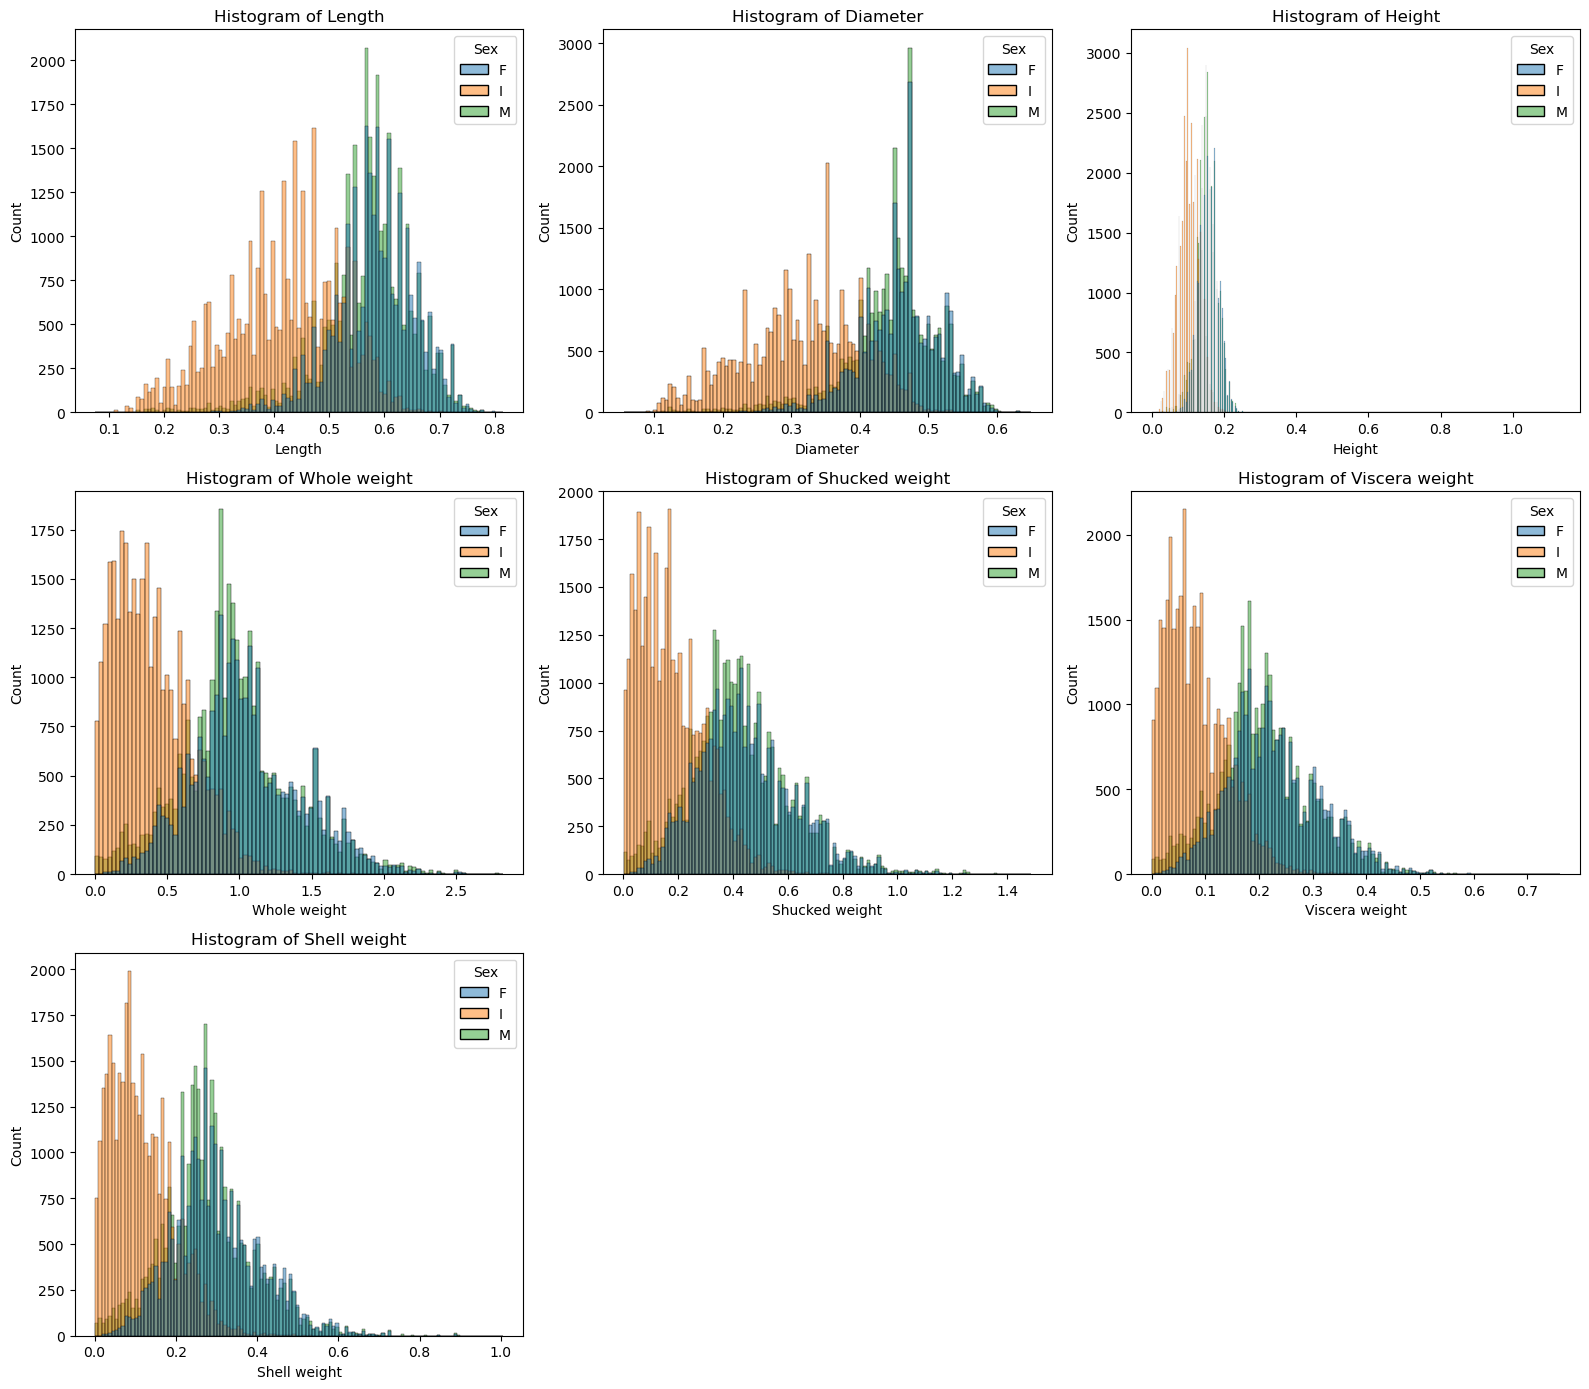

In [24]:
plt.figure(figsize=(16,len(num_features)*2))
for i,col in enumerate(num_features):
    plt.subplot(3,3,i+1)
    sns.histplot(x=col,data=X,hue='Sex')
    plt.title(f"Histogram of {col}")
    plt.tight_layout()
plt.show()

From the above plots, we can observe that except for **Height**, others are not much normal.

Especially, the weight variables are skewed to the left where as **Length** and **Diameter** are somewhat normal. So we need to transform them to make them normal as much as possible.

Next we plot the **Boxcox** and **Yeo-Johnson** transformation for both **Length** and **Diameter**. 

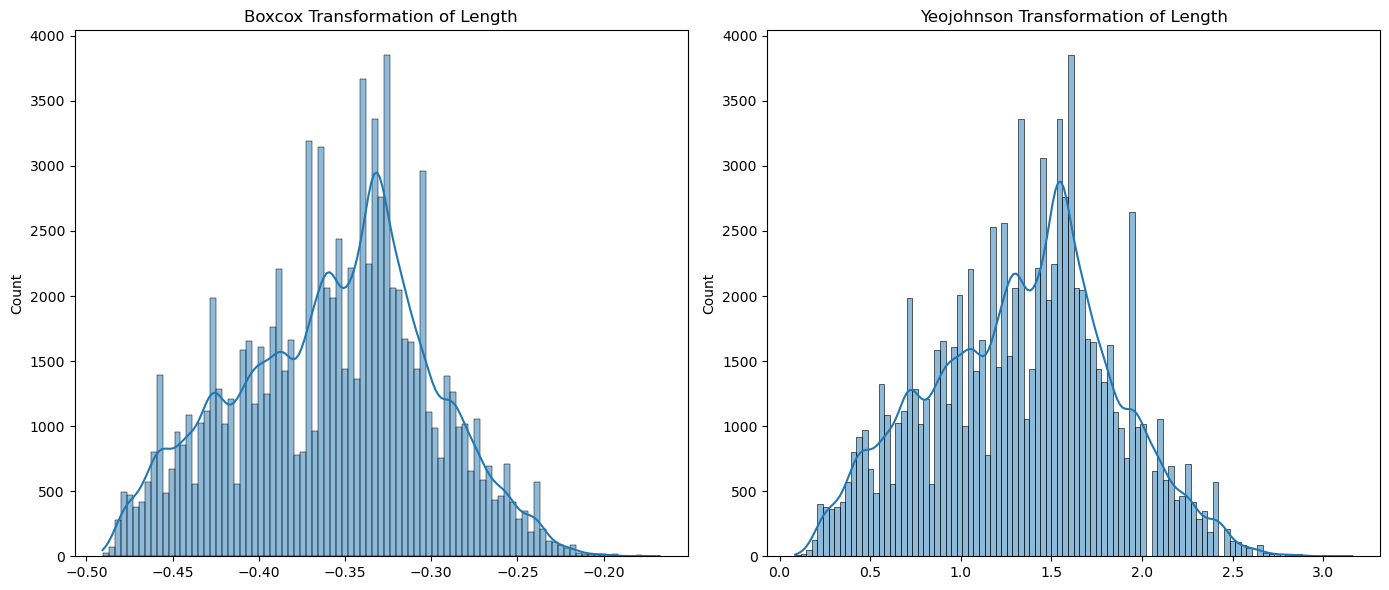

In [25]:
target = X['Length']

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(boxcox(target)[0],kde=True)
plt.title('Boxcox Transformation of Length')
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(yeojohnson(target)[0],kde=True)
plt.title("Yeojohnson Transformation of Length")
plt.tight_layout()

plt.show()

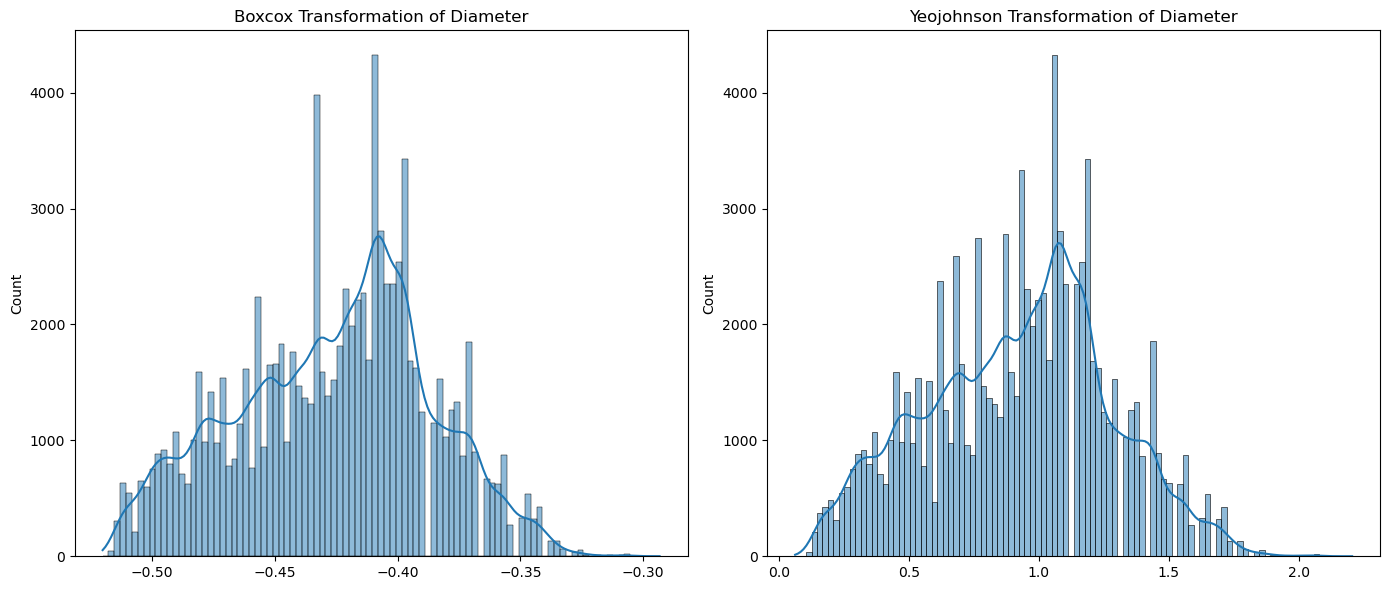

In [26]:
target = X['Diameter']

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(boxcox(target)[0],kde=True)
plt.title('Boxcox Transformation of Diameter')
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(yeojohnson(target)[0],kde=True)
plt.title("Yeojohnson Transformation of Diameter")
plt.tight_layout()

plt.show()

We can observe here that both **Boxcox** and **Yeo-Johnson** transformations are pretty much making the data normal. However **Boxcox** is doing better. Thus we will use **Boxcox** to transform both **Length** and **Diameter**.

Now we try to find the best possible transformation for weight variables. Since all the weight varibles have similar kind of distributions as we have seen in previous plots, we can try the transformation with any one of them and then make sure which one fits better.

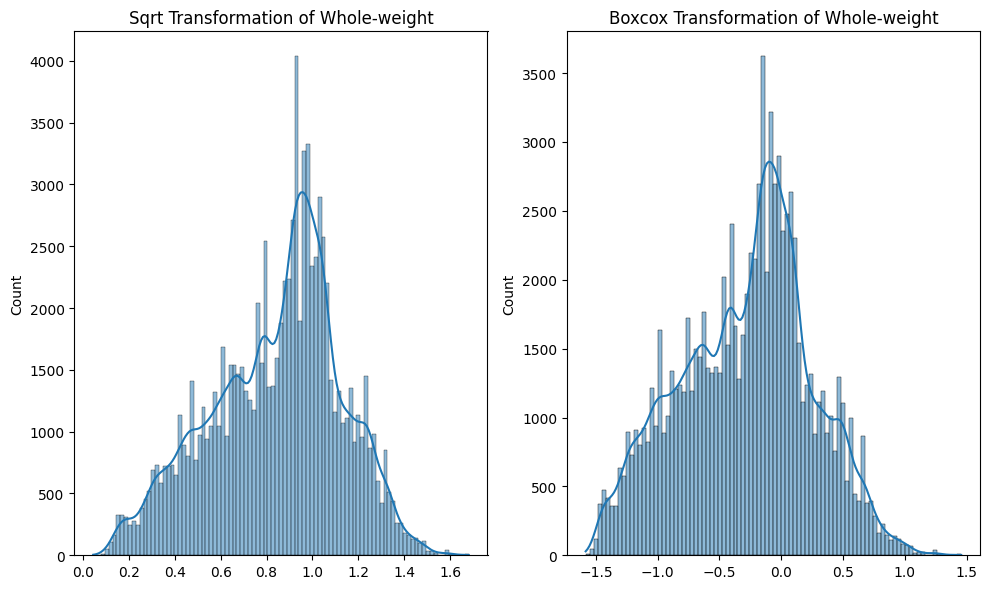

In [16]:
target = X['Whole weight']

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(target**0.5,kde=True)
plt.title('Sqrt Transformation of Whole-weight')
plt.xlabel("")
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(boxcox(target)[0],kde=True)
plt.title("Boxcox Transformation of Whole-weight")
plt.tight_layout()

plt.show()

Here, **square-root** transformation is doing better as compared to **boxcox** transformation. Thus we will apply **square-root** transformation to all of the weight variables.

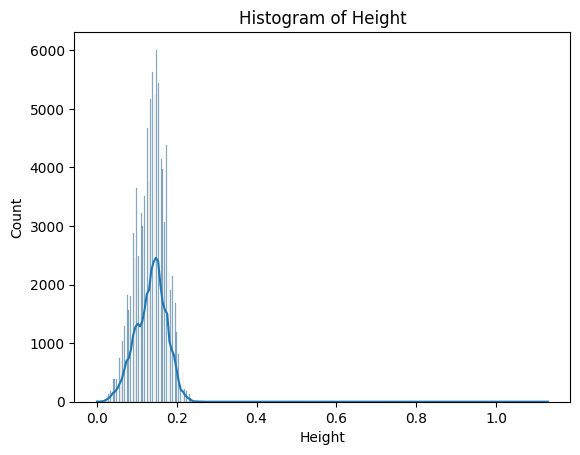

In [17]:
target = X['Height']

sns.histplot(target,kde=True)
plt.title("Histogram of Height")
plt.show()

## Box Plots

Let's plot the box plot for each variables to understand how they are distributed and if they have outliers.

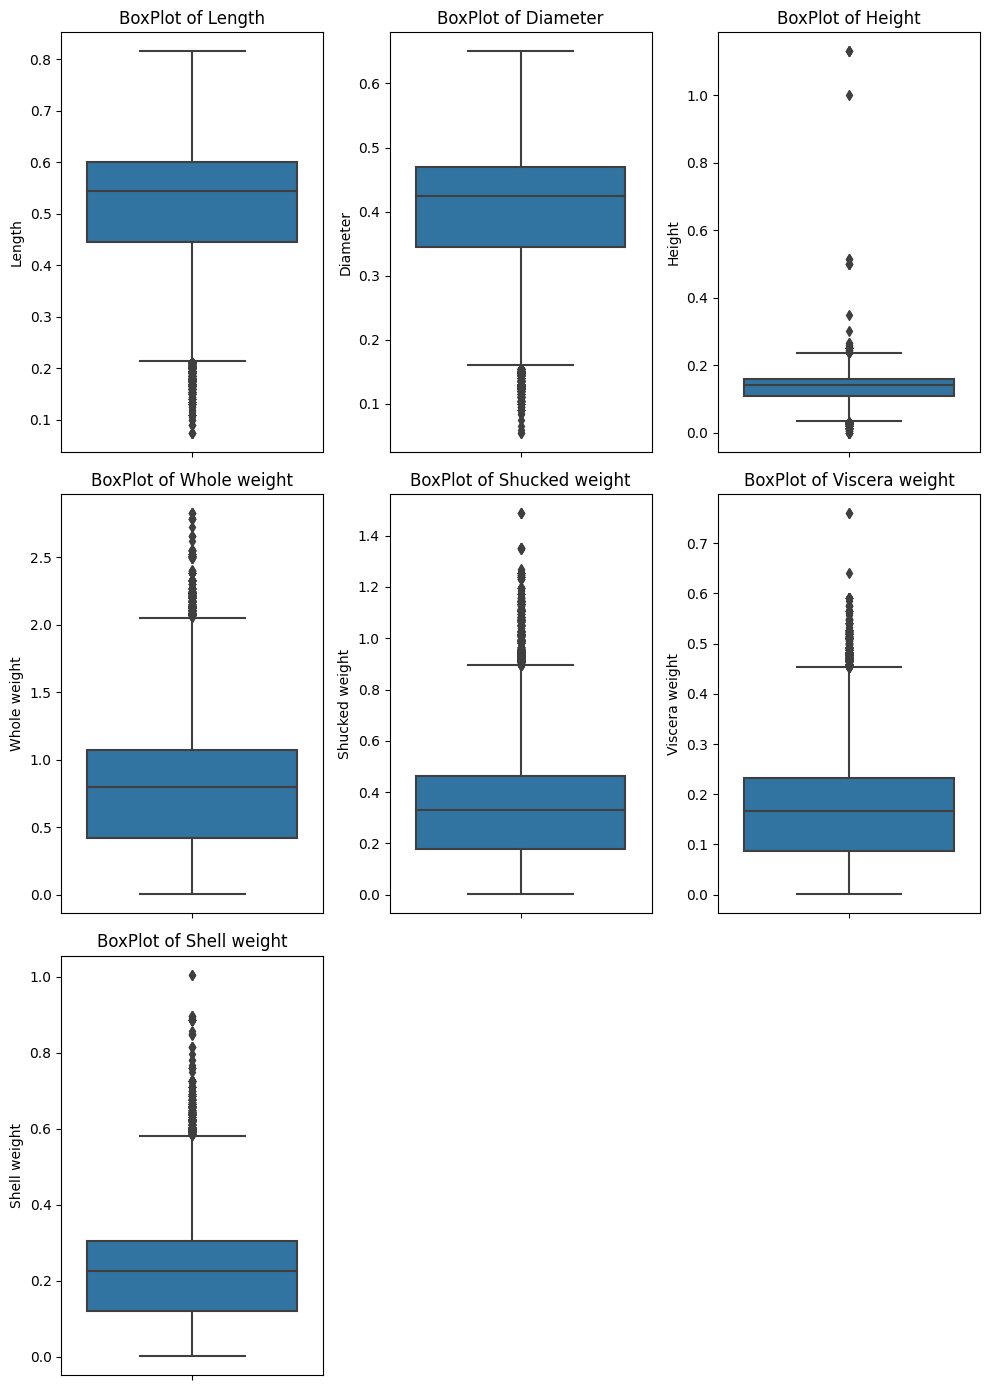

In [18]:
plt.figure(figsize=(10,len(num_features)*2))
for i,col in enumerate(num_features):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=col,data=X)
    plt.title(f"BoxPlot of {col}")
    plt.tight_layout()
plt.show()

**Here we can see that out data have outliers, but we don't need to remove them as models we are going use are not sensitive to outliers. But if you are going to use model that are sensitive to outliers, then make sure to remove them first.**

## Pair Plot

Pair plot show the bivariate distribution of the varibles i.e. how the behave with each other.

<Figure size 1200x800 with 0 Axes>

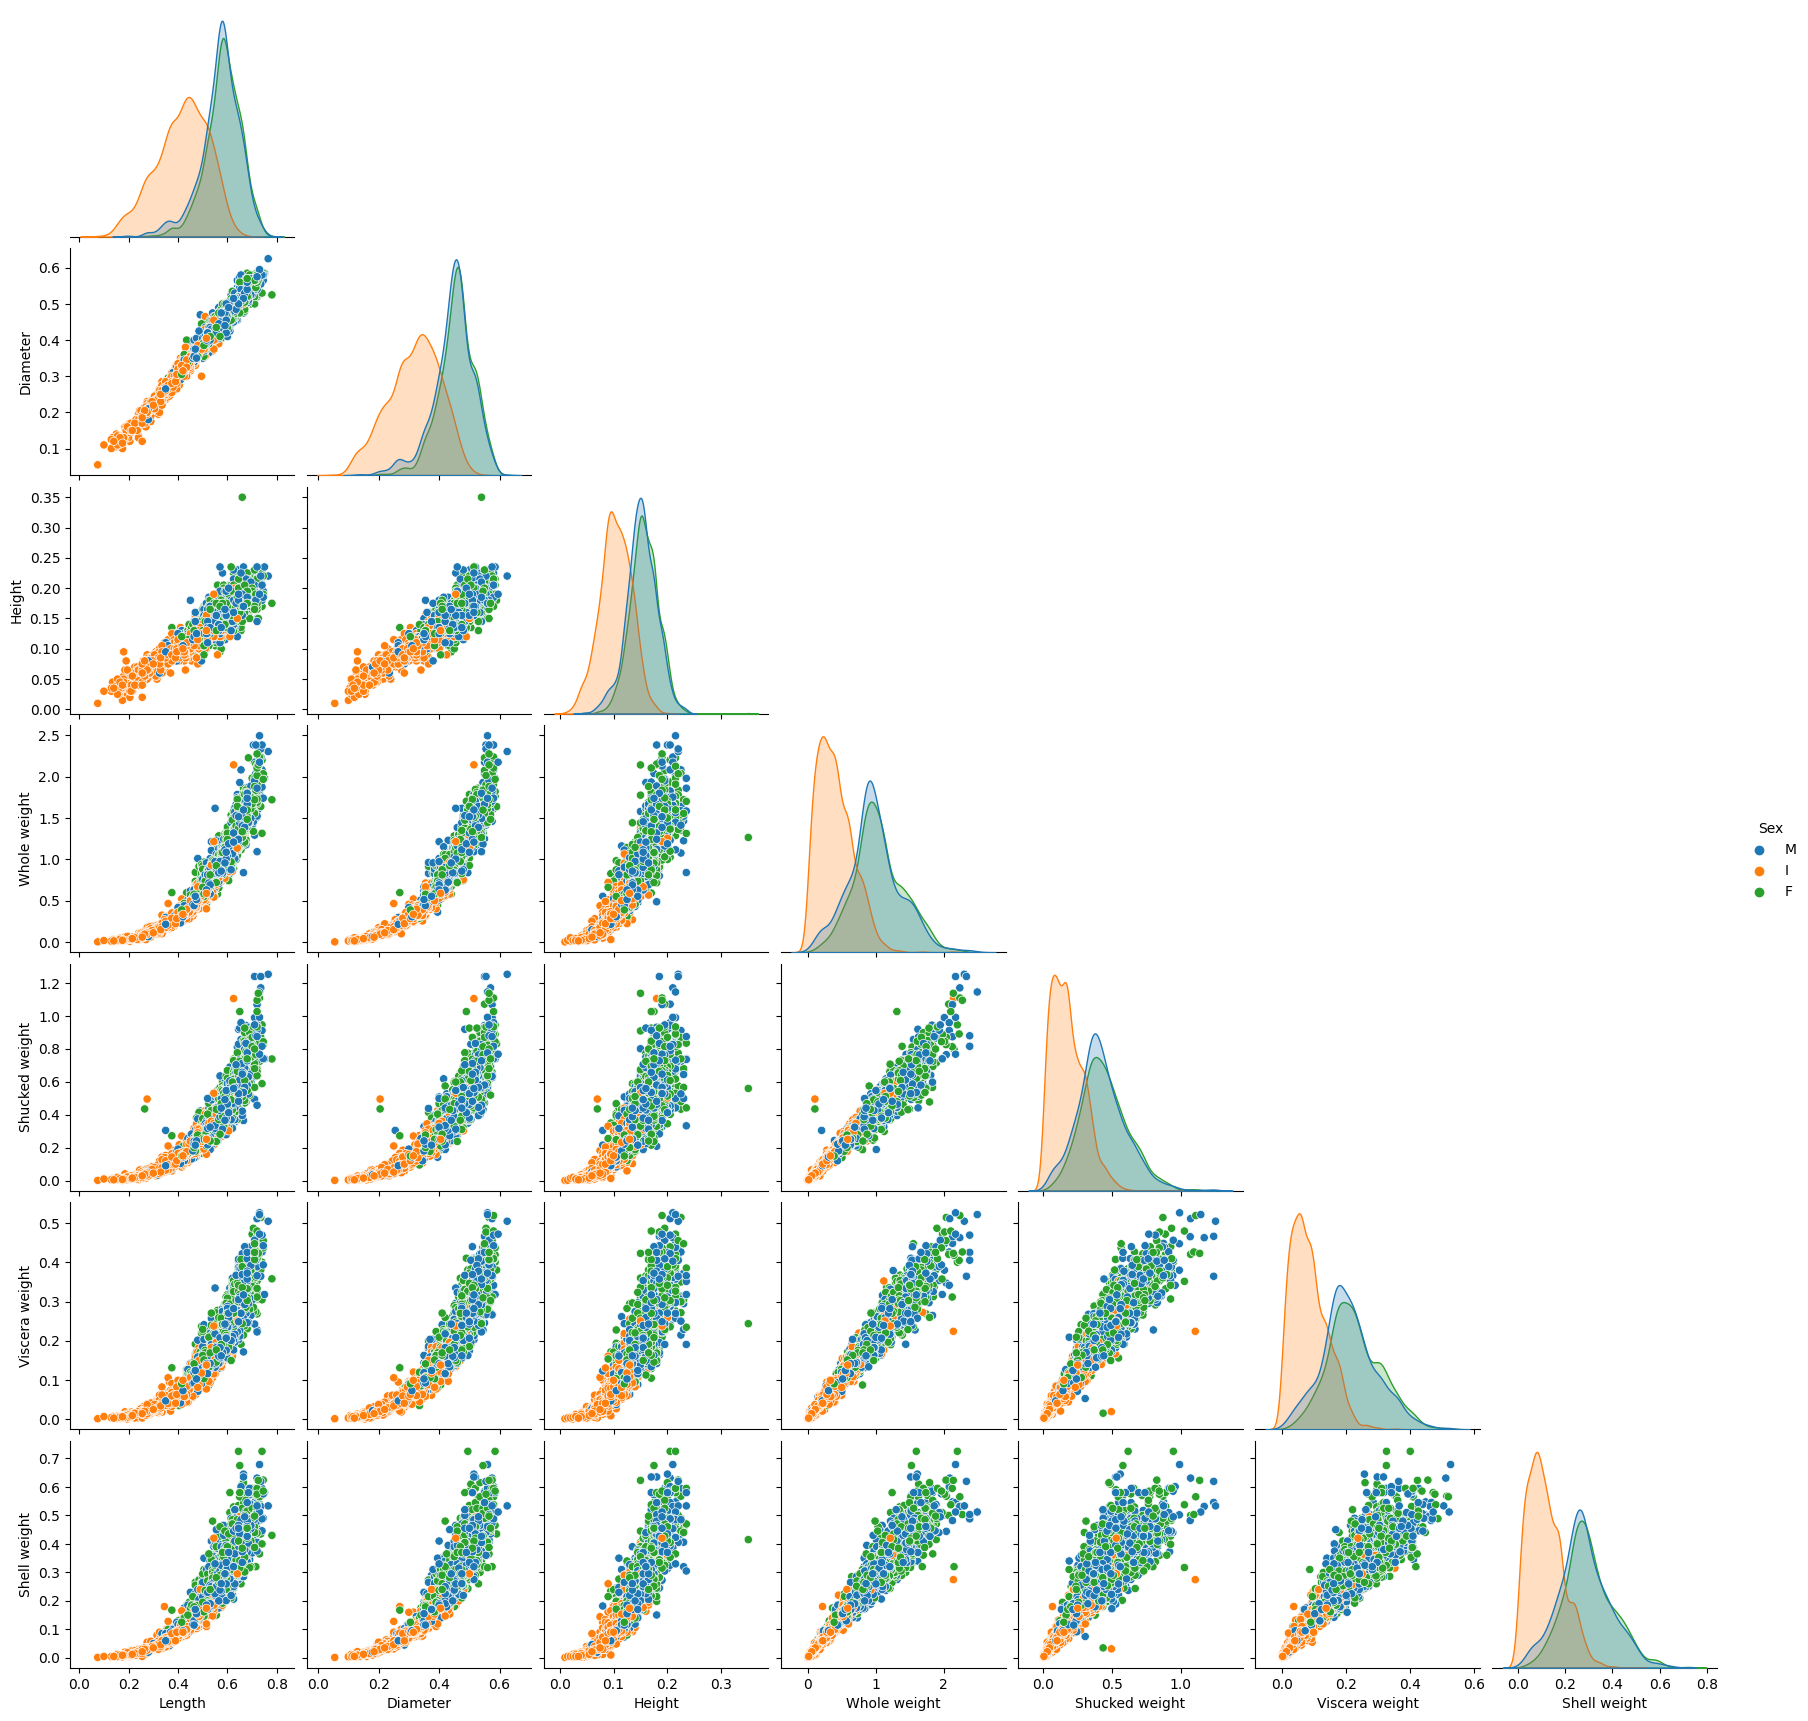

In [19]:
plt.figure(figsize=(12,8))
sns.pairplot(data=X.sample(frac=0.05),hue='Sex',corner=True)
plt.show()

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> TRANSFORMING THE DATA <span style="color:red">|</span></h1>

In [27]:
bc_tf_cols = ['Whole weight','Shucked weight','Viscera weight','Shell weight'] # Columns that require boxcox transformation
sqrt_tf_cols = ['Length','Diameter'] # Columns that require square-root transformation

Next we apply the transformation to our variables.

In [28]:
X[bc_tf_cols] = X[bc_tf_cols].apply(np.sqrt) # box-cox transformation
X[sqrt_tf_cols] = X[sqrt_tf_cols].apply(lambda col:yeojohnson(col)[0]) # yeo-johnson transformation

Since we have one catergorical column **Sex**, we need to encode it. Fot this purpose, we are using **OrdinalEncoder**.

In [29]:
encoder = OrdinalEncoder()

X[['Sex']] = encoder.fit_transform(X[['Sex']])

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> MUTUAL INFORMATION SCORES <span style="color:red">|</span></h1>

**Mutual Information** score helps us to understand how much they tell about the target variable.

Although, mutual info score comes under feature selection, since here we are not creating any new features, so we just want to understand the available features. 

When we create new features from existing one, then we can use this strategy to drop features as well.

In [23]:
discrete_features = X.dtypes == int

def mi_score_maker(X,y,discrete_features):
    scores = mutual_info_regression(X,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':X.columns,
        'Scores':scores
    })
    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

In [24]:
mi_scores = mi_score_maker(X,y.astype('float64'),discrete_features)

mi_scores

,Features,Scores
0,Shell weight,0.669473
1,Whole weight,0.569179
2,Height,0.540781
3,Viscera weight,0.538357
4,Diameter,0.538265
5,Length,0.522558
6,Shucked weight,0.507562
7,Sex,0.238039


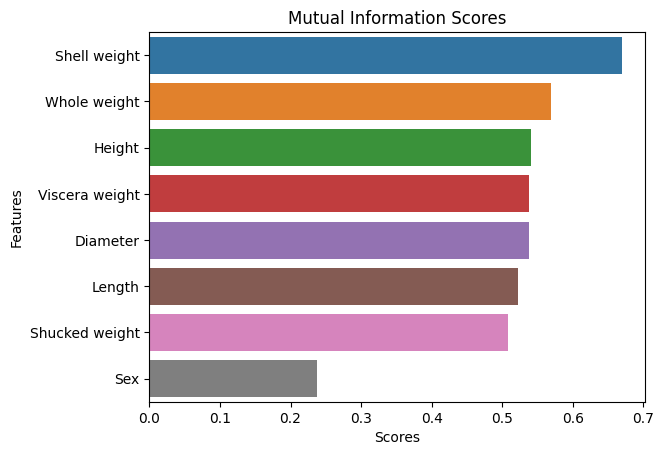

In [25]:
sns.barplot(x='Scores',y='Features',data=mi_scores)
plt.title("Mutual Information Scores")
plt.show()

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> MODEL TRAINING <span style="color:red">|</span></h1>

The models we are going to use are:
* **LGBMRegressor**
* **CatBoostResgressor**
* **XGBRegressor**
* **HistGradientBoosingRegressor**

You can use other models as well. 

Now let's check each model's cross validation score with the dafult values of the parameters.

In [26]:
%%time

lgb_reg = LGBMRegressor(verbose=-1)

score = -cross_val_score(lgb_reg,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()

score**0.5

CPU times: user 5.44 s, sys: 146 ms, total: 5.58 s
Wall time: 5.17 s


0.15114406501378627

In [27]:
%%time

cat_reg = CatBoostRegressor(verbose=False,allow_writing_files=False)

score = -cross_val_score(cat_reg,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()

score**0.5

CPU times: user 2min 38s, sys: 9.91 s, total: 2min 48s
Wall time: 44.6 s


0.15023100494131716

In [28]:
%%time

xgb_reg = XGBRegressor(random_state=42)

score = -cross_val_score(xgb_reg,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()

score**0.5

CPU times: user 4.51 s, sys: 40.8 ms, total: 4.55 s
Wall time: 4.6 s


0.15180551391507427

In [29]:
%%time


hgb_reg = HistGradientBoostingRegressor()

score = -cross_val_score(hgb_reg,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()

score**0.5

CPU times: user 6.9 s, sys: 179 ms, total: 7.08 s
Wall time: 7.08 s


0.15159676249286202

Now we use **optuna** to tune the hyperparameters of the models to get better scores.

In [30]:
# def objective(trial):
#     params = {
#         'n_estimators':trial.suggest_int('n_estimators',100,1000),
#         'eta':trial.suggest_float('eta',0.1,0.5),
#         'max_depth':trial.suggest_int('max_depth',1,32),
#         'gamma':trial.suggest_float('gamma',1e-9,1.0),
#         'subsample':trial.suggest_float('subsample',0.2,1.0),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.1,1.0),
#         'max_leaves':trial.suggest_int('max_leaves',1,32),
#         'grow_policy':trial.suggest_categorical('grow_policy',["depthwise","lossguide"]),
#     }
    
#     model = XGBRegressor(**params,n_jobs=-1,device='cuda')
    
#     score = -cross_val_score(model,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()
#     return score**0.5

# storage = 'sqlite:///xgb_reg.db'
# study_name = 'xgb_reg'

# study = optuna.create_study(storage=storage,
#                             study_name = study_name,
#                             direction='minimize',
#                             sampler=TPESampler(n_startup_trials=15,multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective,n_trials=30)

# print(f'Best Params: {study.best_params}')

In [31]:
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 31, 127),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#     }
    
#     model = LGBMRegressor(**params,verbose=-1,device='gpu')
    
#     score = -cross_val_score(model,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()
#     return score**0.5

# storage = 'sqlite:///lgb_reg.db'
# study_name = 'lgb_reg'

# study = optuna.create_study(storage=storage,
#                             study_name = study_name,
#                             direction='minimize',
#                             sampler=TPESampler(n_startup_trials=75,multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective,n_trials=200)

# print(f"Best Params: {study.best_params}")

In [30]:
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2, log=True),
        "bootstrap_type":trial.suggest_categorical("bootstrap_type",["Bayesian","Bernoulli","MVS"])
    }
    
    params['loss_function'] = 'RMSE'
    
    if params['bootstrap_type'] != 'Bayesian':
        params["subsample"] = trial.suggest_float("subsample", 0.3, 1.0)
    else:
        params['bagging_temperature'] = trial.suggest_int('bagging_temperatur',1,100)
    
    model = CatBoostRegressor(**params,verbose=False,allow_writing_files=False)
    
    score = -cross_val_score(model,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()
    return score**0.5

storage = 'sqlite:///cat_reg.db'
study_name = 'cat_reg'

study = optuna.create_study(storage=storage,
                            study_name = study_name,
                            direction='minimize',
                            sampler=TPESampler(n_startup_trials=30,multivariate=True),
                            load_if_exists=True)

study.optimize(objective,n_trials=100)

print(f"Best Params: {study.best_params}")

[I 2024-04-19 19:37:43,457] A new study created in RDB with name: cat_reg
[I 2024-04-19 19:37:58,670] Trial 0 finished with value: 0.28853989742084224 and parameters: {'depth': 13, 'min_data_in_leaf': 29, 'learning_rate': 0.11645764062459654, 'bootstrap_type': 'Bayesian', 'bagging_temperatur': 64}. Best is trial 0 with value: 0.28853989742084224.
[I 2024-04-19 19:38:55,923] Trial 1 finished with value: 0.15045004821672664 and parameters: {'depth': 8, 'min_data_in_leaf': 14, 'learning_rate': 0.1089325871283383, 'bootstrap_type': 'MVS', 'subsample': 0.9796787102781395}. Best is trial 1 with value: 0.15045004821672664.
[I 2024-04-19 19:39:23,215] Trial 2 finished with value: 0.15050135660383196 and parameters: {'depth': 6, 'min_data_in_leaf': 74, 'learning_rate': 0.12858387415162612, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8039619170824208}. Best is trial 1 with value: 0.15045004821672664.
[I 2024-04-19 19:39:37,054] Trial 3 finished with value: 0.28853989742084274 and parameters: {

KeyboardInterrupt: 

In [34]:
optuna.delete_study(storage=storage,study_name=study_name)

In [33]:
# Values of hyperparameters for different models found after doing hyperparameter tuning using optuna.

xgb_params = {'n_estimators': 631, 
              'eta': 0.10068543574445041, 
              'max_depth': 28, 
              'gamma': 0.737439985663951, 
              'subsample': 0.9517065199210442, 
              'colsample_bytree': 0.7381718259540673, 
              'max_leaves': 23, 
              'grow_policy': 'depthwise'
             }

lgb_params = {'learning_rate': 0.09379817857274081, 
              'num_leaves': 125, 
              'subsample': 0.8431319263894246, 
              'colsample_bytree': 0.5737935980423815, 
              'min_child_samples': 39, 
              'reg_alpha': 8.780851251850981, 
              'reg_lambda': 2.905428856663929,
              'verbose':-1
             }

We will use **VotingRegressor** to combine above models with tuned hyperparameters.

We mainly use voting and stacking to make better predictions with available models.

In [34]:
%%time

voting_reg = VotingRegressor(estimators=[
    ('xgb_reg',XGBRegressor(**xgb_params)),
    ('cat_reg',cat_reg),
    ('lgb_reg',LGBMRegressor(**lgb_params)),
    ('hgb_reg',hgb_reg),
])

score = -cross_val_score(voting_reg,X,y.astype('float'),cv=5,scoring='neg_mean_squared_log_error').mean()

score**0.5

CPU times: user 2min 55s, sys: 8.05 s, total: 3min 3s
Wall time: 1min 14s


0.14963247959202602

Now, we have verified that after using **VotingRegressor**, we get better score as compared to the individual models.

Let's fit our model with training data.

Since we have done out cross validation already, so we can now use the whole dataset to train our final model.

In [35]:
voting_reg.fit(X,y)

VotingRegressor(estimators=[('xgb_reg',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7381718259540673,
                                          device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eta=0.10068543574445041,
                                          eval_metric=None, feature_types=None,
                                          gamma=0.737439985663951,
                                          grow_policy='depthwise',
                                          i...
                                          n_jobs=None, num_parallel_tree=None, ...)),
                            ('cat_reg',
                             <catboost.core.CatBoostRegressor object at 0x7e3ac1c1fcd0>),
                            ('lgb_reg',
                             LGBMRegressor(colsample_bytree=0.5737935980423815,
                                           learning_rate=0.09379817857274081,
                                           min_child_samples=39, num_leaves=125,
                                           reg_alpha=8.780851251850981,
                                           reg_lambda=2.905428856663929,
                                           subsample=0.8431319263894246,
                                           verbose=-1)),
                            ('hgb_reg', HistGradientBoostingRegressor())])

<h1 style="color:indigo; text-align:center"><span style="color:red">|</span> PREDICTION <span style="color:red">|</span></h1>

## Importing data for prediction

In [36]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv',index_col='id')
test_data.columns = X.columns

## Transforming and encoding respective columns

In [37]:
test_data[bc_tf_cols] = test_data[bc_tf_cols].apply(np.sqrt)
test_data[sqrt_tf_cols] = test_data[sqrt_tf_cols].apply(lambda col:yeojohnson(col)[0])

test_data[['Sex']] = encoder.transform(test_data[['Sex']])

## Predicting using final model

In [38]:
pred = voting_reg.predict(test_data)

pred

array([ 9.56672437,  9.76801655, 10.16199428, ..., 12.53429226,
       13.72314616,  8.62352993])

## Saving the predicted data in a csv file

In [39]:
sub = pd.DataFrame({
    'id':test_data.index,
    'Rings':pred
})

sub.to_csv("submission.csv",index=False,header=True)